In [1]:
from cluster_function import *

In [2]:
def load_trajectory(name):
    pdb = 'Tau5R2R3_'+name+'.pdb'
    trajname = 'Tau5R2R3_'+name+'.xtc'
    # traj = md.load(traj_dir+trajname, top=traj_dir+pdb, stride = 10)
    # For testing
    traj = md.load(traj_dir+trajname, top=traj_dir+pdb, stride=10)
    top = traj.topology
    print(traj)
    return top, traj


# Inputs for TSNE: provide distance matrix between all pairs of conformations. The RMSD.dat that I am using in the next line is the pairwise RMSD obtained from Gromacs in binary vector format.
workdir = './'
traj_dir = workdir + 'trajectory/'
all_out_dir = workdir + 'com_E2E7_out/'
traj_out_dir = traj_dir + 'com_E2E7_out/'
if not os.path.exists(all_out_dir):
    os.makedirs(all_out_dir)
if not os.path.exists(traj_out_dir):
    os.makedirs(traj_out_dir)

In [3]:
def calculate_tsne(name, traj):
    outdir = workdir + name + '/'
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    rmsd = np.empty((traj.n_frames, traj.n_frames))
    for i in range(traj.n_frames):
        rmsd[i] = md.rmsd(traj, traj, i)
    print('Max pairwise rmsd: %f nm' % np.max(rmsd))
    rmsd_sym = suv.check_symmetric(rmsd, raise_exception=False)

    with open(outdir + 'status.txt', 'a') as f1:
        f1.write("\n")
        print('symmetry check completed', file=f1)

    # Kmeans clustering
    range_n_clusters = [4, 6, 8, 10, 12, 14, 16, 18, 20]
    perplexityVals = range(100, 2100, 100)

    # Creating the TSNE object and projection
    perplexityVals = range(100, 2100, 100)

    for i in perplexityVals:
        tsneObject = TSNE(n_components=2, perplexity=i, early_exaggeration=10.0, learning_rate=100.0, n_iter=3500,
                          n_iter_without_progress=300, min_grad_norm=1e-7, metric="precomputed", init='random', method='barnes_hut', angle=0.5)
        # metric is precomputed RMSD distance. if you provide Raw coordinates, the TSNE will compute the distance by default with Euclidean metrics
        tsne = tsneObject.fit_transform(rmsd_sym)
        np.savetxt(outdir + "tsnep{0}".format(i), tsne)

    for perp in perplexityVals:
        tsne = np.loadtxt(outdir + 'tsnep'+str(perp))
        for n_clusters in range_n_clusters:
            kmeans = KMeans(n_clusters=n_clusters).fit(tsne)
            np.savetxt(outdir + 'kmeans_'+str(n_clusters)+'clusters_centers_tsnep' +
                       str(perp), kmeans.cluster_centers_, fmt='%1.3f')
            np.savetxt(outdir + 'kmeans_'+str(n_clusters)+'clusters_tsnep' +
                       str(perp)+'.dat', kmeans.labels_, fmt='%1.1d')
    # Compute silhouette score based on low-dim and high-dim distances
            silhouette_ld = silhouette_score(tsne, kmeans.labels_)
            np.fill_diagonal(rmsd_sym, 0)
            silhouette_hd = metrics.silhouette_score(
                rmsd_sym, kmeans.labels_, metric='precomputed')
            with open(outdir + 'silhouette.txt', 'a') as f:
                f.write("\n")
                print(perp, n_clusters, silhouette_ld, silhouette_hd,
                      silhouette_ld*silhouette_hd, file=f)


In [4]:
traj_name_list = ['apo', 'epi002', 'epi7170', 'CYE', 'CYE7']

apo_top, apo_traj = load_trajectory('apo')
epi002_top, epi002_traj = load_trajectory('epi002')
epi7170_top, epi7170_traj = load_trajectory('epi7170')
CYE_top, CYE_traj = load_trajectory('CYE')
CYE7_top, CYE7_traj = load_trajectory('CYE7')


<mdtraj.Trajectory with 5715 frames, 739 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 4951 frames, 793 atoms, 59 residues, and unitcells>
<mdtraj.Trajectory with 5516 frames, 800 atoms, 59 residues, and unitcells>
<mdtraj.Trajectory with 5975 frames, 791 atoms, 58 residues, and unitcells>
<mdtraj.Trajectory with 5687 frames, 798 atoms, 58 residues, and unitcells>


In [5]:
def get_CA_trajectory(top, traj, name):
    ca_selection = top.select('name CA')
    traj_new = traj.atom_slice(ca_selection)
    print(traj_new)
    md.Trajectory.save_dcd(traj_new, traj_dir + '%s_CA.dcd' % name)
    return traj_new


apo_CA = get_CA_trajectory(apo_top, apo_traj, 'apo')
epi002_CA = get_CA_trajectory(epi002_top, epi002_traj, 'epi002')
epi7170_CA = get_CA_trajectory(epi7170_top, epi7170_traj, 'epi7170')
CYE_CA = get_CA_trajectory(CYE_top, CYE_traj, 'CYE')
CYE7_CA = get_CA_trajectory(CYE7_top, CYE7_traj, 'CYE7')

apo_CA_sel = apo_top.select('name CA')
apo_CA_traj_new = apo_traj.atom_slice(apo_CA_sel)
md.Trajectory.save_pdb(apo_CA_traj_new[0], traj_dir + 'apo_CA.pdb')


<mdtraj.Trajectory with 5715 frames, 56 atoms, 56 residues, and unitcells>
<mdtraj.Trajectory with 4951 frames, 56 atoms, 56 residues, and unitcells>
<mdtraj.Trajectory with 5516 frames, 56 atoms, 56 residues, and unitcells>
<mdtraj.Trajectory with 5975 frames, 56 atoms, 56 residues, and unitcells>
<mdtraj.Trajectory with 5687 frames, 56 atoms, 56 residues, and unitcells>


In [6]:
traj_1 = md.load(traj_dir+'apo_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_2 = md.load(traj_dir+'epi002_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_3 = md.load(traj_dir+'epi7170_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_4 = md.load(traj_dir+'CYE_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_5 = md.load(traj_dir+'CYE7_CA.dcd', top=traj_dir+'apo_CA.pdb')
traj_CA_combined = md.join([traj_2, traj_3])
top_CA_combined = traj_CA_combined.topology
print(traj_CA_combined)


<mdtraj.Trajectory with 10467 frames, 56 atoms, 56 residues, and unitcells>


In [7]:
ligand_residue_index_list = [58, 58, 14, 14]
contact_traj_list = [epi002_traj, epi7170_traj, CYE_traj, CYE7_traj]
ligand_ring_list = [[[759, 757, 753, 747, 752, 756], [751, 746, 750, 754, 758, 755]], [[759, 760, 761, 763, 771, 773], [757, 758, 742, 743, 744, 745]], [[200, 201, 202, 203, 211, 212], [193, 194, 195, 196, 213, 214]], [[200, 201, 202, 203, 210, 211], [193, 194, 195, 196, 213, 212]]]
ligand_hbond_donor_list = [[[744, 792], [742, 790], [743, 791]], [[768, 796], [750, 784], [752, 787]], [[210, 235], [208, 232], [190, 217]], [[208, 231], [190, 216]]]
ligand_residue_index_list = ligand_residue_index_list[0:2]
contact_traj_list = contact_traj_list[0:2]
ligand_ring_list = ligand_ring_list[0:2]
ligand_hbond_donor_list = ligand_hbond_donor_list[0:2]

print(ligand_hbond_donor_list)

[[[744, 792], [742, 790], [743, 791]], [[768, 796], [750, 784], [752, 787]]]


In [8]:
ligand_residue_index_list = [58, 58, 14, 14]
contact_traj_list = [epi002_traj, epi7170_traj, CYE_traj, CYE7_traj]
ligand_ring_list = [[[759, 757, 753, 747, 752, 756], [751, 746, 750, 754, 758, 755]], [[759, 760, 761, 763, 771, 773], [757, 758, 742, 743, 744, 745]], [[200, 201, 202, 203, 211, 212], [193, 194, 195, 196, 213, 214]], [[200, 201, 202, 203, 210, 211], [193, 194, 195, 196, 213, 212]]]
ligand_hbond_donor_list = [[[744, 792], [742, 790], [743, 791]], [[768, 796], [750, 784], [752, 787]], [[210, 235], [208, 232], [190, 217]], [[208, 231], [190, 216]]]
ligand_residue_index_list = ligand_residue_index_list[0:2]
contact_traj_list = contact_traj_list[0:2]
ligand_ring_list = ligand_ring_list[0:2]
ligand_hbond_donor_list = ligand_hbond_donor_list[0:2]

contact_array = np.empty([1, 58])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    contact = calc_contact(t, l)
    contact_array = np.append(contact_array, contact, axis=0)
contact_array = np.delete(contact_array, 0, 0)

hphob_array = np.empty([1, 58])
for t,l in zip(contact_traj_list, ligand_residue_index_list):
    hphob = calc_hphob(t, l)
    hphob_array = np.append(hphob_array, hphob, axis=0)
hphob_array = np.delete(hphob_array, 0, 0)

aromatic_array = np.empty([1, 58])
for t,l in zip(contact_traj_list, ligand_ring_list):
    aromatic = calc_aromatic(t, l)
    aromatic_array = np.append(aromatic_array, aromatic, axis=0)
aromatic_array = np.delete(aromatic_array, 0, 0)

hbond_array = np.empty([1, 58])
for t,l,d in zip(contact_traj_list, ligand_residue_index_list, ligand_hbond_donor_list):
    hbond = calc_hbond(t, l, d)
    hbond_array = np.append(hbond_array, hbond, axis=0)
hbond_array = np.delete(hbond_array, 0, 0)

print(contact_array.shape, hphob_array.shape, aromatic_array.shape, hbond_array.shape)

Lig_ring.0
Lig_ring.1
Lig_ring.0
Lig_ring.1
(10467, 58) (10467, 58) (10467, 58) (10467, 58)


In [9]:
h_res = []
for res in apo_traj.topology.residues:
    h_res.append(res.resSeq)
h_residues = len(set(h_res))
residue_offset = 390
hres_renum = np.asarray(h_res)+residue_offset

apo_dssp = md.compute_dssp(apo_traj, simplified=True)
apo_dssp_array = np.array(apo_dssp)
epi002_dssp = md.compute_dssp(epi002_traj, simplified=True)[:, 0:58]
epi7170_dssp = md.compute_dssp(epi7170_traj, simplified=True)[:, 0:58]
CYE_dssp = md.compute_dssp(CYE_traj, simplified=True)[:, 0:58]
CYE7_dssp = md.compute_dssp(CYE7_traj, simplified=True)[:, 0:58]
dssp_all = np.concatenate(
    (epi002_dssp, epi7170_dssp))
dssp_all_H, dssp_all_E = dssp_convert(dssp_all)

helixpdb = '/home/daisy/Documents/Research/AR_Paper/Trajectory_Files_12.20.21/R2R3_all_helix.pdb'
helixBB = md.load_pdb(helixpdb)

Sa_total = calc_Sa(traj_CA_combined, helixBB)
rg_CA = calc_rg(traj_CA_combined)

contact_map_apo = contact_map(apo_traj)
contact_map_epi002 = contact_map(epi002_traj)
contact_map_epi7170 = contact_map(epi7170_traj)
contact_map_CYE = contact_map(CYE_traj)
contact_map_CYE7 = contact_map(CYE7_traj)

/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:685: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


In [10]:
contact_map_CA = calc_contact_map_CA(traj_CA_combined)

In [11]:
# calculate_tsne('com_E2E7_cluster_tsne', traj_CA_combined)


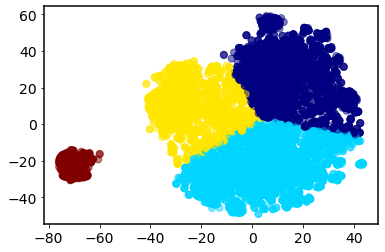

<Figure size 432x288 with 0 Axes>

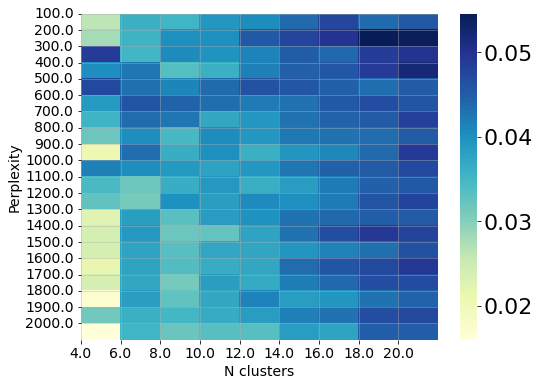

In [12]:
outdir = workdir + 'com_E2E7_cluster_tsne/'
range_n_clusters = [4, 6, 8, 10, 12, 14, 16, 18, 20]

##### plotting for the best cluster with highest silhouette score######
s = np.loadtxt(outdir + 'silhouette.txt')
[bestP, bestK] = [300, 4]
besttsne = np.loadtxt(outdir + 'tsnep'+str(int(bestP)))
bestclust = np.loadtxt(outdir + 'kmeans_'+str(int(bestK)) +
                       'clusters_tsnep'+str(int(bestP))+'.dat')
plt.rc('font', family='sans-serif', weight='normal', size='14')
plt.rc('axes', linewidth=1.5)
cmap = cm.get_cmap('jet', bestK)
plt.scatter(besttsne[:, 0], besttsne[:, 1],
            c=bestclust.astype(float), s=50, alpha=0.5, cmap=cmap)
plt.savefig(outdir + 'tsnep'+str(int(bestP)) +
            '_kmeans'+str(int(bestK))+'.png', dpi=300)
plt.savefig(all_out_dir + 'tsnep'+str(int(bestP)) +
            '_kmeans'+str(int(bestK))+'.png', dpi=300)
plt.savefig(all_out_dir + 'tsnep'+str(int(bestP)) +
            '_kmeans'+str(int(bestK))+'.pdf', dpi=300)
plt.show()

plt.clf()

len(s[:, 4])
n_cluster_columns = np.reshape(s[:, 1], (20, len(range_n_clusters)))[0]
perp_columns = np.reshape(s[:, 0], (20, len(range_n_clusters)))[:, 0]
sil_score = np.reshape(s[:, 4], (20, len(range_n_clusters)))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
im = sns.heatmap(sil_score, cmap='YlGnBu', ax=ax)
ax.grid(which='both', alpha=0.5)
#plt.xticks(range(1,57), sequence, rotation=45, size=14)
plt.yticks(range(0, 20), perp_columns, rotation=0, size=14)
plt.xticks(range(0, 9), n_cluster_columns, rotation=0, size=14)
plt.xlabel("N clusters")
plt.ylabel("Perplexity")

#plt.yticks(range(1, 57), sequence, rotation=45, size=14)
cbar = im.collections[0].colorbar
# cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=22)
# ax.invert_xaxis()
len(perp_columns)
plt.savefig(all_out_dir + 'silhouette_heatmap.png',
            dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'silhouette_heatmap.pdf',
            dpi=300, bbox_inches='tight')


In [13]:
bestclust_int = bestclust.astype(int)
c_members = {i: np.where(bestclust_int == i)[0] for i in range(int(bestK))}
with open('c_members'+str(bestK)+'.txt', 'w') as f:
    print(c_members, file=f)


def find_indices(list_to_check, item_to_find):
    array = np.array(list_to_check)
    indices = np.where(array == item_to_find)[0]
    return list(indices)


cdef = {}
clusters = []
for x in bestclust_int:
    if x not in clusters:
        clusters.append(x)
print(clusters)
n_cluster = len(clusters)

c_dict = {}
for i in clusters:
    ind = find_indices(bestclust_int, i)
    c_dict[i] = np.array(ind)

for key in c_dict:
    print(len(c_dict[key]))
    print(len(c_dict[key])/len(bestclust_int))

average_H1_H = np.zeros((n_cluster, 3))
for key in c_dict:
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[key]])
    average_H1_H[key, 0] = key
    average_H1_H[key, 1] = np.mean(H1_H[:, 0])

sort_H = np.sort(average_H1_H[:, 1])
for i in range(len(sort_H)):
    index = np.where(average_H1_H[:, 1] == sort_H[i])[0]
    average_H1_H[index, 2] = int(n_cluster-i)
print(average_H1_H)


[0, 2, 1, 3]
3714
0.354829464029808
2006
0.19164994745390274
4087
0.3904652718066304
660
0.06305531670965893


/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:685: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


[[0.         0.28299723 2.        ]
 [1.         0.31098605 1.        ]
 [2.         0.19625606 3.        ]
 [3.         0.02964995 4.        ]]


In [14]:
traj_len_array = np.array([traj_2.n_frames, traj_3.n_frames])
print(traj_len_array)
# marker_list = ['.', '^', '1', 'P', '+']
marker_list = ['+', 'x']
title_list = [ 'EPI-002', 'EPI-7170']
color_list = ['C0', 'C1',]


[4951 5516]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

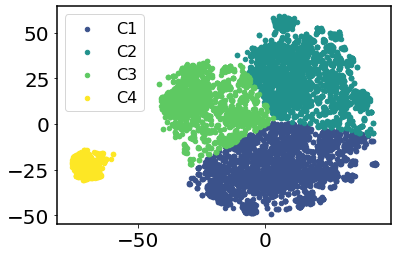

In [15]:
##### plotting for the best cluster with highest silhouette score######
s = np.loadtxt(outdir + 'silhouette.txt')
[bestP, bestK] = [300, 4]
besttsne = np.loadtxt(outdir + 'tsnep'+str(int(bestP)))
bestclust = np.loadtxt(outdir + 'kmeans_'+str(int(bestK)) +
                       'clusters_tsnep'+str(int(bestP))+'.dat')
# plt.figure(figsize=(8, 6))
plt.rc('font', family='sans-serif', weight='normal', size=14)
plt.rc('axes', linewidth=1.5)
cmap = cm.get_cmap('jet', bestK)

for i in range(1, n_cluster+1):
    index = np.where(average_H1_H[:, 2] == i)[0]
    plt.scatter(besttsne[np.where(bestclust == index)[0], 0], besttsne[np.where(
        bestclust == index)[0], 1], s=20, alpha=1, c=plt.cm.viridis(round(256/n_cluster)*(i)), label='C'+str(i))

plt.tick_params(axis='both', labelsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(
    0, 1), fontsize=16, ncol=1)
# plt.title('t-SNE', fontsize=20)
plt.savefig(all_out_dir + 'tsne_color.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'tsne_color.pdf', dpi=300, bbox_inches='tight')

In [16]:
count = 0
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    count = count + traj_len_array[i]
    print('For ' + title_list[i] + ':')
    for c_num in range(0, n_cluster):
        perct = np.where(bestcluster == c_num)[0].shape[0]/bestcluster.shape[0]
        print('In cluster ' + str(c_num) + ': ' + str(perct))


For EPI-002:
In cluster 0: 0.3336699656635023
In cluster 1: 0.3732579276913755
In cluster 2: 0.1599676832963038
In cluster 3: 0.13310442334881842
For EPI-7170:
In cluster 0: 0.373821609862219
In cluster 1: 0.4059100797679478
In cluster 2: 0.22008701957940538
In cluster 3: 0.00018129079042784627


In [17]:
count = 0
df = pd.DataFrame(columns=['Cluster', 'EPI-002', 
                  'EPI-7170'], index=range(1, n_cluster+1))
for i in range(0, len(traj_len_array)):
    bestcluster = bestclust_int[count:count+traj_len_array[i]]
    count = count + traj_len_array[i]
    for c_num in range(1, n_cluster+1):
        key = np.where(average_H1_H[:, 2] == c_num)[0]
        perct = np.where(bestcluster == key)[0].shape[0]/bestcluster.shape[0]
        df['Cluster'][c_num] = c_num
        df[title_list[i]][c_num] = perct
print(df)


  Cluster   EPI-002  EPI-7170
1       1  0.373258   0.40591
2       2   0.33367  0.373822
3       3  0.159968  0.220087
4       4  0.133104  0.000181


/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:685: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:685: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]
/home/daisy/Documents/Research/AR_Paper/Zhu_et_al_9.11.24_data/cluster_function.py:685: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum(((gamma/s)**2*2**arange(1, d+1)[::-1])[::-1]))[::-1]


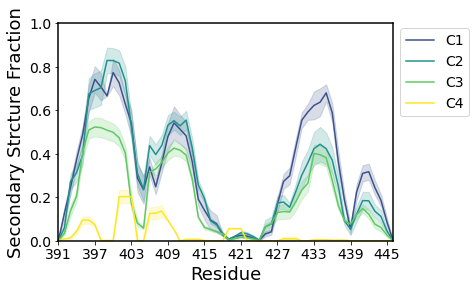

In [18]:
for i in range(1, n_cluster+1):
    key = int(np.where(average_H1_H[:, 2] == i)[0])
    H1_H, H1_E = dssp_convert(dssp_all[c_dict[key]])
    plt.plot(hres_renum, H1_H[:, 0], label='C%s' %
             i, color=plt.cm.viridis(round(256/n_cluster)*i))
    plt.fill_between(hres_renum, H1_H[:, 0]-H1_H[:, 1],
                     H1_H[:, 0]+H1_H[:, 1], alpha=0.2, color=plt.cm.viridis(round(256/n_cluster)*i))
plt.ylim(0, 1.0)
plt.xlim(391, 446)
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01), fontsize=14, ncol=1)
plt.xticks(np.arange(391, 446, 6))
plt.savefig(all_out_dir + 'helical_fill.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'helical_fill.pdf', dpi=300, bbox_inches='tight')


Text(0.09, 0.5, 'Contact Probability')

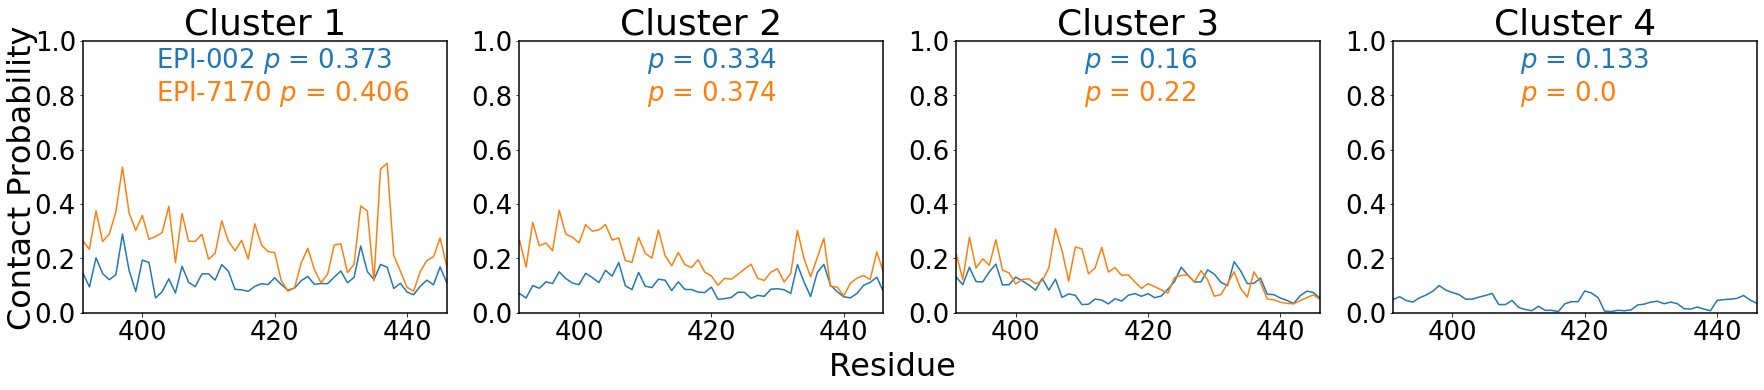

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(30, 5))
# fig.suptitle('Ligand contact', size = 36, y=1)
for i in range(0, n_cluster):
    key = int(np.where(average_H1_H[:, 2] == i+1)[0])
    frame_ind = c_dict[key]
    count = 0
    bf = []
    for ind in range(len(title_list)):
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        count += traj_len_array[ind]
        contact_frame = np.sum(contact_array[frame_new], axis = 1)
        contact_binary = np.where(contact_frame>0,1,0)
        bf.append(np.average(contact_binary))
        fig_label = "%s Bound fraction : %s \nClsuter population : %s" % (title_list[ind], str(round(bf[ind],2)), str(round(df[title_list[ind]][i+1],2)))
        if i == 3 and ind == 1:
            continue
        ax[i].plot(hres_renum, np.average(contact_array[frame_new], axis=0), color = color_list[ind], label=fig_label)
    ax[i].set_title('Cluster %s' % str(i+1), size=36)
    # ax[i].legend(loc = 'upper left', bbox_to_anchor=(0, 1.01), fontsize=14, ncol=1)
    ax[i].tick_params(axis='both', labelsize=26)
    ax[i].set_xlim(391, 446)
    ax[i].set_ylim(0, 1.0)
    if i == 0:
        t1 = "%s $\it{p}$ = %s" % (str(title_list[0]), str(round(df[title_list[0]][i+1],3)))
        t2 = "%s $\it{p}$ = %s" % (str(title_list[1]), str(round(df[title_list[1]][i+1],3)))
        textbox1 = ax[i].text(0.2, 0.9, t1, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[0])
        textbox2 = ax[i].text(0.2, 0.78, t2, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[1])
    else:
        t1 = "$\it{p}$ = %s" % str(round(df[title_list[0]][i+1],3))
        t2 = "$\it{p}$ = %s" % str(round(df[title_list[1]][i+1],3))
        textbox1 = ax[i].text(0.35, 0.9, t1, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[0])
        textbox2 = ax[i].text(0.35, 0.78, t2, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[1])
    textbox1.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    textbox2.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
fig.text(0.5, -0.05, 'Residue', ha='center',fontsize=32)
fig.text(0.09, 0.5, 'Contact Probability', va='center', rotation='vertical',fontsize=32)

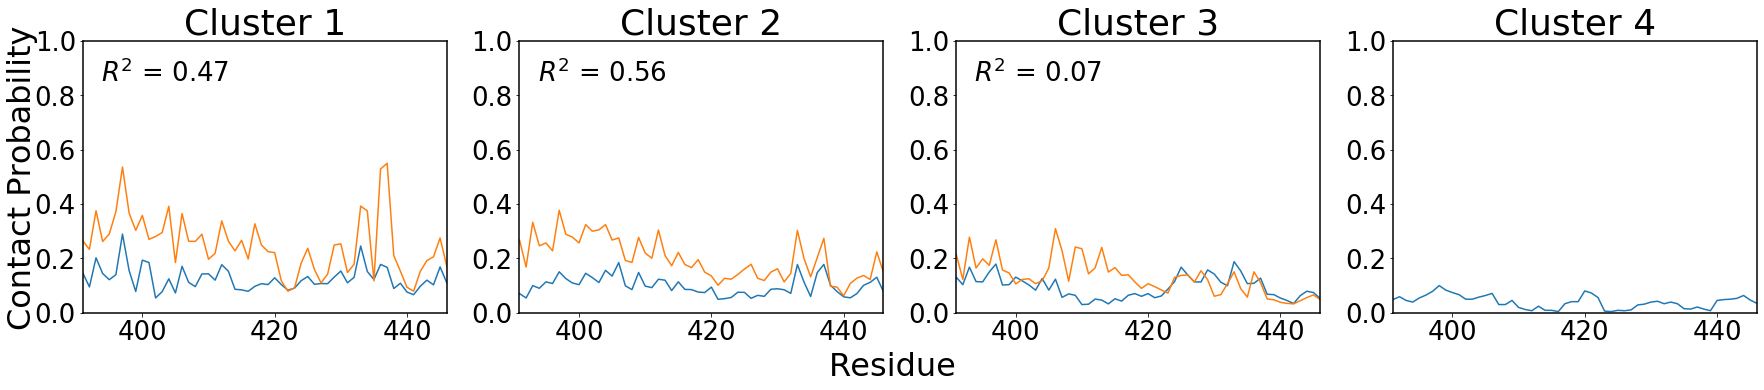

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(30, 5))
# fig.suptitle('Ligand contact', size = 36, y=1)
for i in range(0, n_cluster):
    key = int(np.where(average_H1_H[:, 2] == i+1)[0])
    frame_ind = c_dict[key]
    count = 0
    bf = []
    y = []
    for ind in range(len(title_list)):
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        count += traj_len_array[ind]
        contact_frame = np.sum(contact_array[frame_new], axis = 1)
        contact_binary = np.where(contact_frame>0,1,0)     
        if i == 3 and ind == 1:
            continue
        y.append(np.average(contact_array[frame_new], axis=0))
        ax[i].plot(hres_renum, np.average(contact_array[frame_new], axis=0), color = color_list[ind], label='%s' % title_list[ind])
     
    ax[i].set_title('Cluster %s' % str(i+1), size=36)
    # ax[3].legend(loc = 'upper left', bbox_to_anchor=(0, 1.01), fontsize=18, ncol=1)
    ax[i].tick_params(axis='both', labelsize=26)
    ax[i].set_xlim(391, 446)
    ax[i].set_ylim(0, 1.0)
    if i == 3:
        continue
    else:
        r2 = sp.stats.pearsonr(y[0], y[1])[0] ** 2      
    t1 = "$R^2$ = %s" % (str(round(r2, 2)))
    textbox1 = ax[i].text(0.05, 0.85, t1, transform=ax[i].transAxes, fontsize=26, wrap = True)
    textbox1.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    # if i == 0:
    #     t1 = "%s" % (str(title_list[0]))
    #     t2 = "%s" % (str(title_list[1]))
    #     textbox2 = ax[i].text(0.05, 0.7, t1, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[0])
    #     textbox3 = ax[i].text(0.05, 0.58, t2, transform=ax[i].transAxes, fontsize=26, wrap = True, color = color_list[1])
    # textbox2.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    # textbox3.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
fig.text(0.5, -0.05, 'Residue', ha='center',fontsize=32)
fig.text(0.09, 0.5, 'Contact Probability', va='center', rotation='vertical',fontsize=32)

plt.savefig(all_out_dir + 'contact_correlation.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'contact_correlation.pdf', dpi=300, bbox_inches='tight')

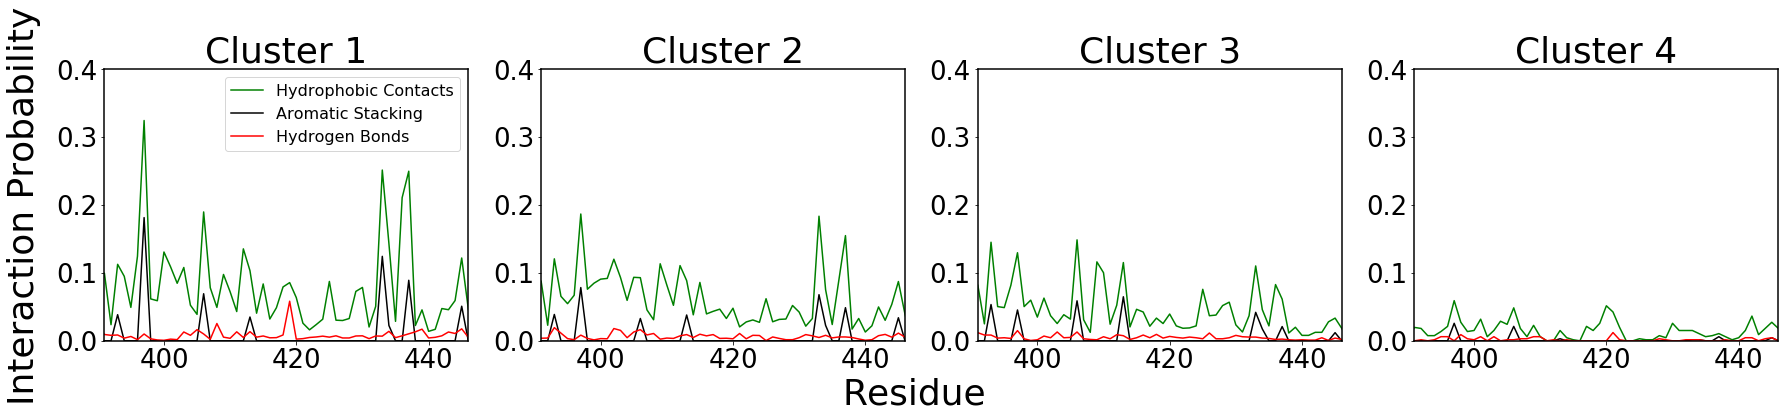

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(30, 5))
# fig.suptitle('Ligand interaction', size = 36, y=1.05)
for i in range(0, n_cluster):
    key = int(np.where(average_H1_H[:, 2] == i+1)[0])
    frame_ind = c_dict[key]
    ax[i].plot(hres_renum, np.average(hphob_array[frame_ind], axis=0), color = 'green', label = 'Hydrophobic Contacts')
    ax[i].plot(hres_renum, np.average(aromatic_array[frame_ind], axis=0), color = 'black', label = 'Aromatic Stacking')
    ax[i].plot(hres_renum, np.average(hbond_array[frame_ind], axis=0), color = 'red', label = 'Hydrogen Bonds')    
    ax[i].set_title('Cluster %s' % str(i+1), size=36)
    ax[i].tick_params(axis='both', labelsize=26)
    ax[i].set_xlim(391, 446)
    ax[i].set_ylim(0, 0.4)
    ax[0].legend(fontsize = 16)
    # if i == 0:
    #     t1 = "%s \np = %s" % (str(title_list[0]), str(round(df[title_list[0]][i+1],3)))
    #     t2 = "%s \np = %s" % (str(title_list[1]), str(round(df[title_list[1]][i+1],3)))
    #     textbox1 = ax[i].text(0.35, 0.83, t1, transform=ax[i].transAxes, fontsize=20, wrap = True, color = color_list[0])
    #     textbox2 = ax[i].text(0.35, 0.63, t2, transform=ax[i].transAxes, fontsize=20, wrap = True, color = color_list[1])
    # else:
    #     t1 = "$\it{p}$ = %s" % str(round(df[title_list[0]][i+1],3))
    #     t2 = "$\it{p}$ = %s" % str(round(df[title_list[1]][i+1],3))
    #     textbox1 = ax[i].text(0.35, 0.9, t1, transform=ax[i].transAxes, fontsize=20, wrap = True, color = color_list[0])
    #     textbox2 = ax[i].text(0.35, 0.8, t2, transform=ax[i].transAxes, fontsize=20, wrap = True, color = color_list[1])
    textbox1.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
    textbox2.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
fig.text(0.5, -0.05, 'Residue', ha='center',fontsize=36)
fig.text(0.08, 0.5, 'Interaction Probability', va='center', rotation='vertical',fontsize=36)

plt.savefig(all_out_dir + 'ligand_contact.png', dpi=300, bbox_inches='tight')
plt.savefig(all_out_dir + 'ligand_contact.pdf', dpi=300, bbox_inches='tight')

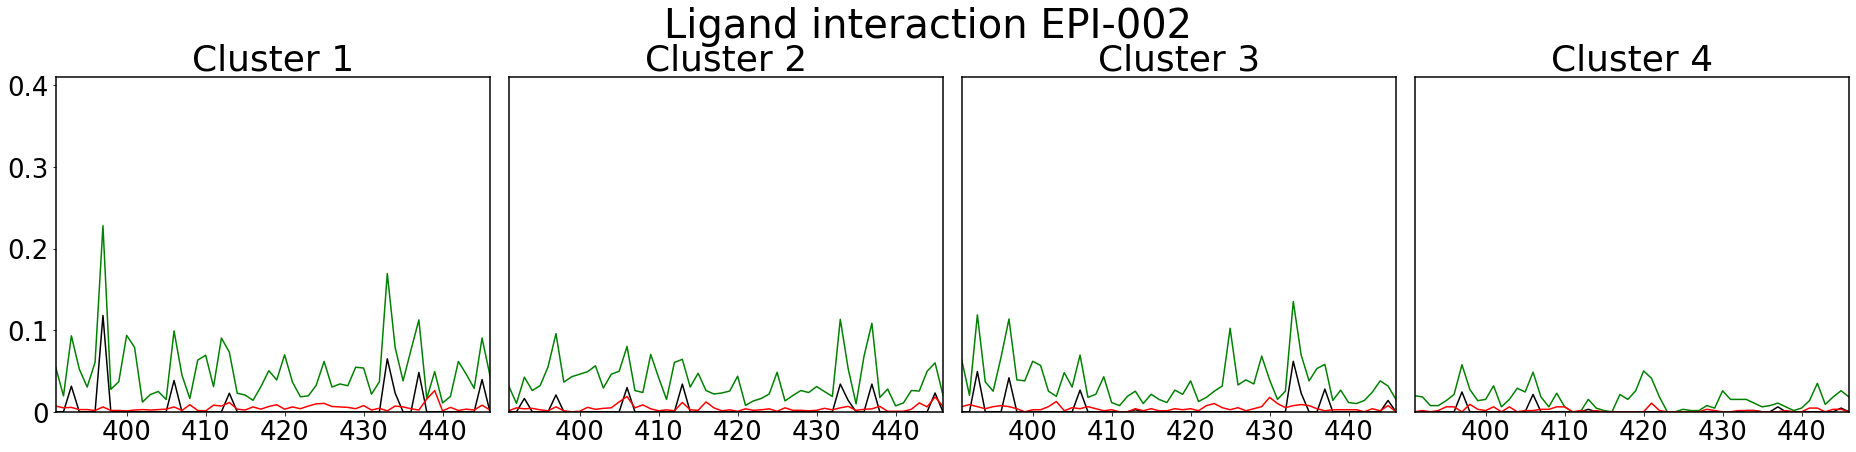

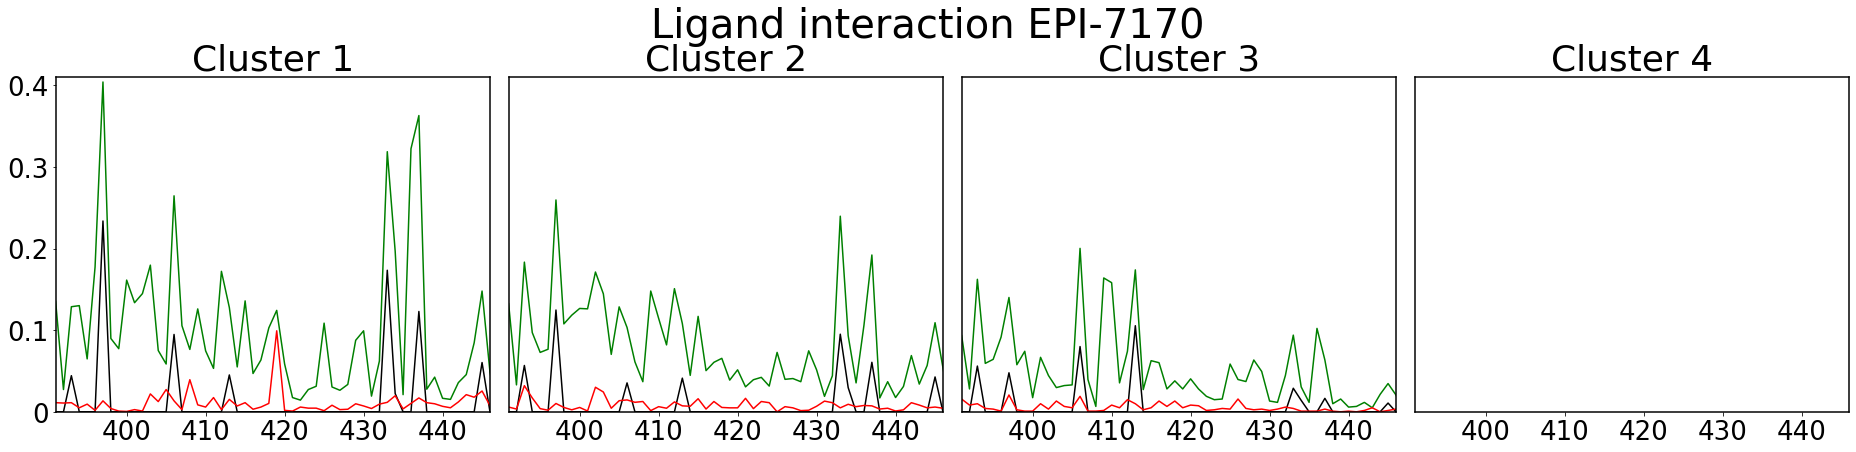

In [32]:
count = 0
np.set_printoptions(precision=2)
for ind in range(len(title_list)):
    fig, ax = plt.subplots(1, 4, figsize=(26, 6))
    ax = ax.flatten()
    for i in range(0, n_cluster):
        key = int(np.where(average_H1_H[:, 2] == i+1)[0])
        frame_ind = c_dict[key]
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        ax[i].set_title('Cluster %s' % str(i+1), size=36)
        ax[i].tick_params(axis='both', labelsize=20)
        ax[i].set_xlim(391, 446)
        ax[i].set_ylim(0, 0.41)
        if i > n_cluster-5:
            ax[i].set_xticklabels(size = 26, labels = ([390, 400, 410, 420, 430, 440]))
        else:
            ax[i].set_xticks([])
        if i % 4 == 0:
            ax[i].set_yticklabels(size = 26, labels = ([0, 0.1, 0.2, 0.3, 0.4]))
        else:
            ax[i].set_yticks([])
        if i == 3 and ind == 1:
            continue
        ax[i].plot(hres_renum, np.average(hphob_array[frame_new], axis=0), color = 'green')
        ax[i].plot(hres_renum, np.average(aromatic_array[frame_new], axis=0), color = 'black')
        ax[i].plot(hres_renum, np.average(hbond_array[frame_new], axis=0), color = 'red')    
    fig.suptitle('Ligand interaction %s' % title_list[ind], size = 40, y=1.05)
    count += traj_len_array[ind]
    fig.tight_layout()
    plt.savefig(all_out_dir + 'ligand_interaction_%s.png'% title_list[ind], dpi=300, bbox_inches='tight')
    plt.savefig(all_out_dir + 'ligand_interaction_%s.pdf'% title_list[ind], dpi=300, bbox_inches='tight')

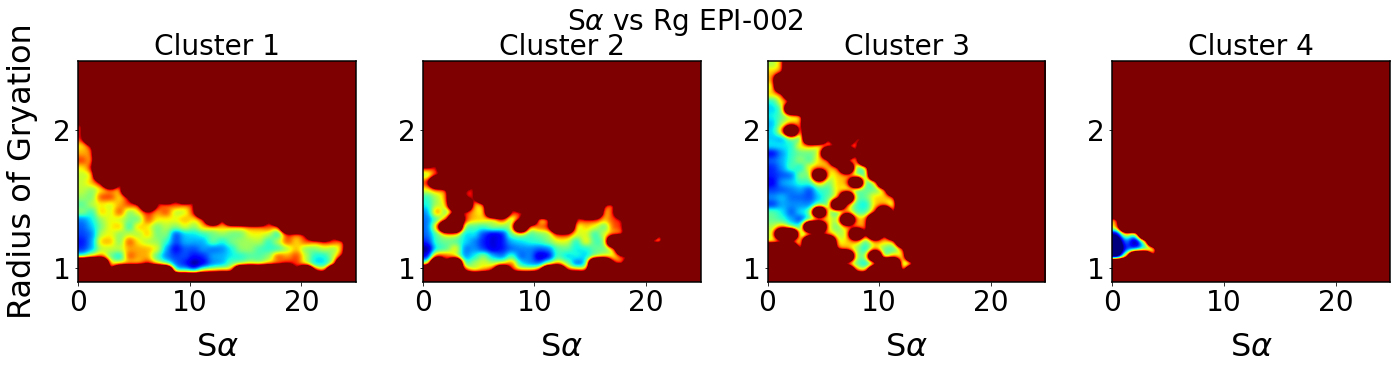

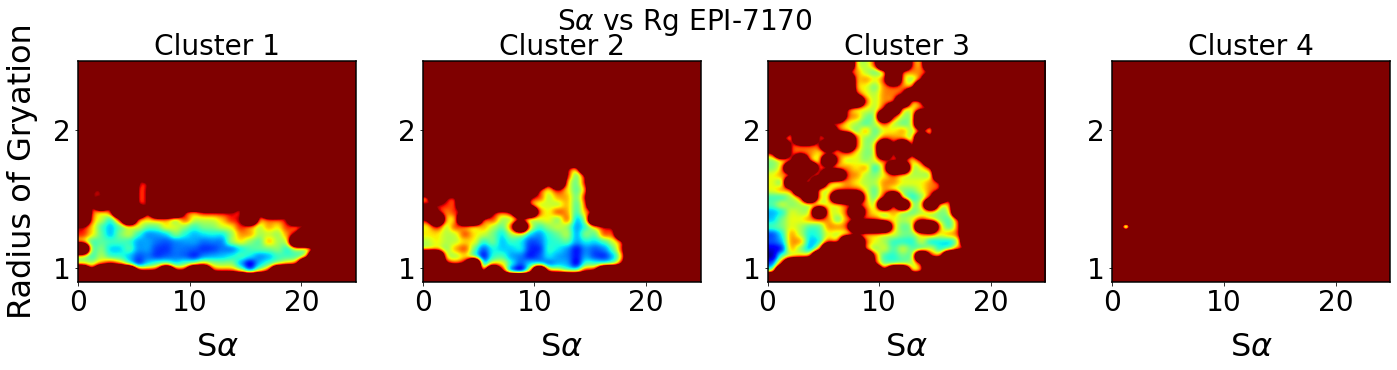

In [33]:
count = 0
for ind in range(len(title_list)):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax = ax.flatten()
    for i in range(0, n_cluster):
        key = int(np.where(average_H1_H[:, 2] == i+1)[0])
        frame_ind = c_dict[key]
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        a, xedges, yedges = np.histogram2d(rg_CA[frame_new], Sa_total[frame_new], 30, [
            [0.9, 2.5], [0, 25.0]], normed=True, weights=None)
        a = np.log(np.flipud(a)+.000001)
        T = 300
        a = -(0.001987*T)*a

        im = ax[i].imshow(a, interpolation='gaussian', extent=[
            yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
        im.set_clim(0.1, 3)
        ax[i].set_xlim(0, 24.9)
        if i % 4 == 0:
            ax[i].set_ylabel("Radius of Gryation", size=32, labelpad=15)
        if i > n_cluster - 5:
            ax[i].set_xlabel(r'S$\alpha$', size=32, labelpad=15)
        ax[i].set_title('Cluster %s' %
                                    str(i+1), fontsize=28)
        ax[i].tick_params(axis='both', labelsize=28)
    fig.suptitle(r'S$\alpha$' + ' vs Rg %s' % title_list[ind], size = 28, y=1.03)
    count += traj_len_array[ind]
    fig.tight_layout()
    plt.savefig(all_out_dir + 'SaRg_%s.png'% title_list[ind], dpi=300, bbox_inches='tight')
    plt.savefig(all_out_dir + 'SaRg_%s.pdf'% title_list[ind], dpi=300, bbox_inches='tight')

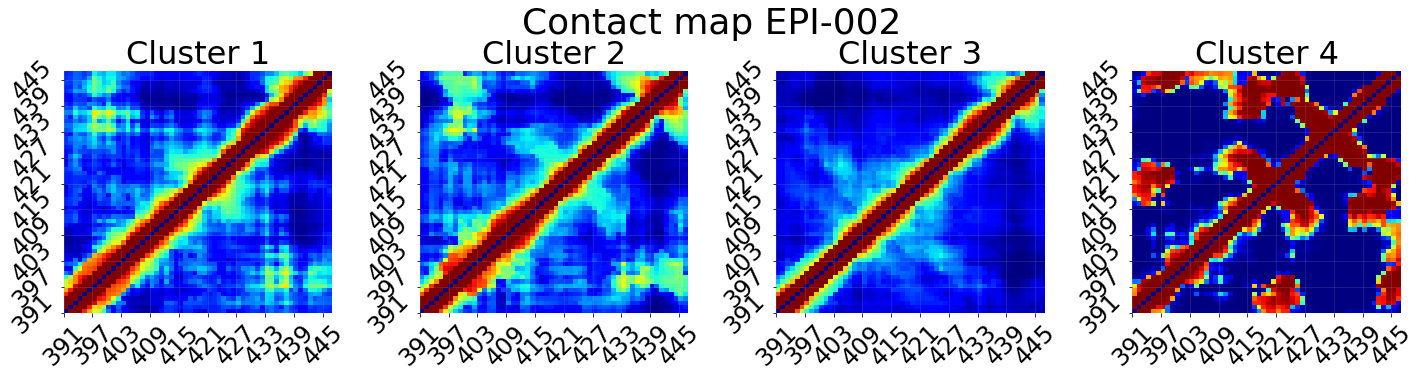

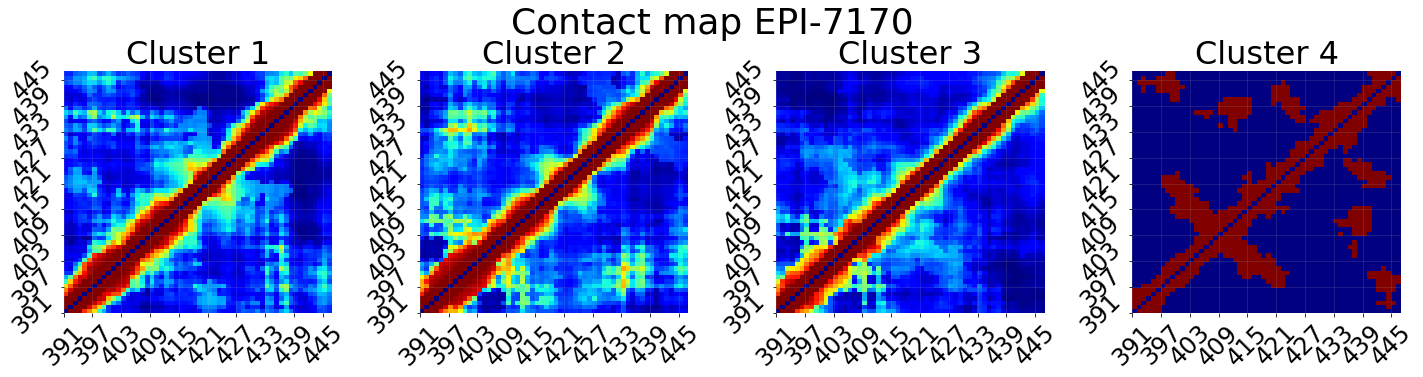

In [40]:
sequence = []
for i in range(1, 57):
    new_i = i+390
    if i % 6 == 1:
        sequence.append(str(new_i))

count = 0
for ind in range(len(title_list)):
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    ax = ax.flatten()
    for i in range(0, n_cluster):
        key = int(np.where(average_H1_H[:, 2] == i+1)[0])
        frame_ind = c_dict[key]
        frame_new = frame_ind[np.where((frame_ind < count + traj_len_array[ind]) &(frame_ind > count))]
        axis = ax[i]
        plt.sca(axis)
        contact_map_CA = calc_contact_map_CA(traj_CA_combined[frame_new])
        im = sns.heatmap(contact_map_CA, cmap='jet', ax=axis, cbar=False)
        axis.invert_yaxis()
        plt.grid(which='both', alpha=0.2)
        plt.xticks(np.arange(0, 56, 6), sequence, rotation = 45, fontsize=24)
        plt.yticks(np.arange(0, 56, 6), sequence, rotation = 45, fontsize=24)
        plt.title('Cluster %s' % str(i+1), fontsize=32)
    fig.tight_layout()
    fig.suptitle('Contact map %s' % title_list[ind], size = 36, y=1.05)
    count += traj_len_array[ind]
    plt.savefig(all_out_dir + 'contact_map_%s.png'% title_list[ind], dpi=300, bbox_inches='tight')
    plt.savefig(all_out_dir + 'contact_map_%s.pdf'% title_list[ind], dpi=300, bbox_inches='tight')